<a href="https://colab.research.google.com/github/christellezouein/image-colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization


In this notebook I base myself on the [Deep Koalarization: Image Colorization usingCNNs and Inception-Resnet-v2](https://arxiv.org/pdf/1712.03400.pdf) paper to implement a neural network to colorize black and white images.

The data I use to train and test the network can be found [here](https://www.floydhub.com/emilwallner/datasets/colornet/2).

To run on TPU:

In [50]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.101.143.218:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.101.143.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.101.143.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


When I tried running everything on TPU, when training the model, I got an `Unavailable: {{function_node __inference_train_function_243071}} failed to connect to all addresses`. So I am running the notebook on GPU instead.

To run on GPU:  (When TPU is unavailable)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Opening and reading images

In [4]:
from google.colab import files
files.upload()

Saving data.tar.gz to data.tar (1).gz


In [2]:
!tar -xvf data.tar.gz

Streaming output truncated to the last 5000 lines.
data/images/Train/nC5sag.jpg
data/images/Train/Fpp7MY.jpg
data/images/Train/photo-1418874478290-e7bc1086d373.jpeg
data/images/Train/lisXOi.jpg
data/images/Train/vaB7Oi.jpg
data/images/Train/gaySzj.jpg
data/images/Train/04DG4Y.jpg
data/images/Train/photo-1481513724834-908d369dee05.jpeg
data/images/Train/ibWrtY.jpg
data/images/Train/elreAG.jpg
data/images/Train/4fYX7i.jpg
data/images/Train/s2DRcr.jpg
data/images/Train/RhP50e.jpg
data/images/Train/i0phhD.jpg
data/images/Train/4HL86u.jpg
data/images/Train/CJSCQ8.jpg
data/images/Train/photo-1485713001145-a8f2145fbbff.jpeg
data/images/Train/m81Z1G.jpg
data/images/Train/0BOzM1.jpg
data/images/Train/photo-1500725888018-14763f9502da.jpeg
data/images/Train/VADK8x.jpg
data/images/Train/1u4qID.jpg
data/images/Train/f2O4aT.jpg
data/images/Train/0GV8YA.jpg
data/images/Train/mv7uoK.jpg
data/images/Train/photo-1496051287082-e579300c6dc9.jpeg
data/images/Train/wx3hxn.jpg
data/images/Train/K5C4N0.jpg
da

In [2]:
!ls

 data  'data.tar (1).gz'   data.tar.gz	 results   sample_data


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

sample image shape:  (256, 256, 3)


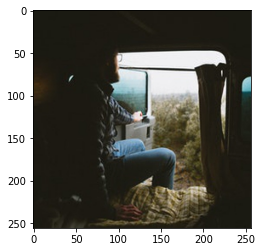

In [4]:
sample_image_name = !ls data/train/images/ | head -n 1
sample_image = imread("data/train/images/{}".format(sample_image_name[0]))

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

### The Lab color space

In the [paper](https://arxiv.org/pdf/1712.03400.pdf) I'm basing myself on, the researchers assume there's a mapping $\mathcal{F}$ such as $\mathcal{F} : X_L \longrightarrow (\tilde X_a, \tilde X_b)$, where $X_L$ is the luminance component or greyscale image and $\tilde X_a$ and $\tilde X_b$ are the $a$, $b$ components of the reconstructed image, which combined with the input give the estimated colored image $\tilde X = (X_L, \tilde X_a, \tilde X_b)$. 

And thus we consider images in the $Lab$ colorspace where $L$ is the luminance, $a$ is the green-red color spectrum and $b$ is the blue-yellow color spectrum.

In [5]:
# Image values have to be between 0 and 1 for the Lab conversion to work.
sample_image_lab = rgb2lab(sample_image/255.0)

In [6]:
# Extracting each Lab channel and converting it to RGB for display.
def extract_lab_chan(img, dim):
    x = np.zeros(img.shape)
    if dim != 0:
        x[:, :, 0] = 80  # necessary so for minimal brightness.
    x[:, :, dim] = img[:, :, dim]
    return lab2rgb(x)

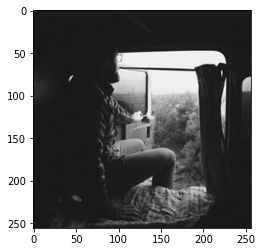

In [7]:
plt.imshow(extract_lab_chan(sample_image_lab, 0));  # L channel

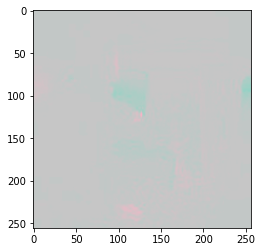

In [8]:
plt.imshow(extract_lab_chan(sample_image_lab, 1));  # green-red channel

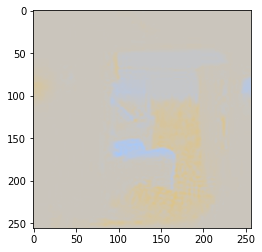

In [9]:
plt.imshow(extract_lab_chan(sample_image_lab, 2));  # blue-yellow

### Loading Inception ResNet v2

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

In [11]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):  # forcing Keras to run on GPU
  inception = InceptionResNetV2(weights=None, include_top=True)
  inception.load_weights("data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")

### Encoder

In [12]:
from tensorflow.keras.layers import Input, Conv2D

In [52]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):
  encoder_input = Input(shape=(224, 224, 1,))  #  Shape of the L channel of an image.  TODO resize 256x256x3 to 224x224x3
  encoder_output = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_input)
  encoder_output = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
  encoder_output = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)

### Fusion

In [53]:
from tensorflow.keras.layers import RepeatVector, Reshape, concatenate

In [54]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):
  fusion_input = Input(shape=(1000,))
  fusion_output = RepeatVector(28 * 28)(fusion_input)  # HW/8**2
  fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
  fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
  fusion_output = Conv2D(256, (1, 1), strides=(1, 1), padding="same", activation="relu")(fusion_output)

### Decoder

In [55]:
from tensorflow.keras.layers import UpSampling2D

In [56]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):
  decoder_output = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu")(fusion_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)  # Upsampling to twice the size of the input.
  decoder_output = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
  decoder_output = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)
  decoder_output = Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
  decoder_output = Conv2D(2, (3, 3), strides=(1, 1), padding="same", activation="tanh")(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)

### Model

In [57]:
from tensorflow.keras.models import Model

In [58]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):
  model = Model(inputs=[encoder_input, fusion_input], outputs=decoder_output)

### Data

In [59]:
from skimage.transform import resize
from skimage.color import gray2rgb, rgb2gray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Creating inception embedding by resizing images to suit inception input size and predicting on said input.

In [60]:
def inception_embedding(grayscaled_rgb_imgs):
  resized = []
  for img in grayscaled_rgb_imgs:
    resized.append(resize(img, (299, 299, 3), mode="constant"))
  inception_output = inception.predict(preprocess_input(np.array(resized)))
  return inception_output

Preprocessing function to scale images to fall in the 0-1 range:

In [61]:
def preprocess_image(img):
  img = img_to_array(img) / 255.0 
  return np.array(img)

In [62]:
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True,
        preprocessing_function=preprocess_image)

In [63]:
batch_size = 32
batch_size

32

In [64]:
def img_gen(batch_size, path="data/train/"):
  for batch in datagen.flow_from_directory(path, target_size=(224, 224), batch_size=batch_size, class_mode=None):
    grayscaled_rgb_imgs = gray2rgb(rgb2gray(batch))   # We get gray images in the RGB color scope.
    batch_lab = rgb2lab(batch)
    grayscaled_rgb_imgs = np.array(grayscaled_rgb_imgs)
    batch_lab = np.array(batch_lab)
    X_batch = batch_lab[:, :, :, 0]  # first channel of every image in the batch. Resulting shape is (batch_size, 224, 224)
    # Adding a dimension: X_batch shape will be (batch_size, 224, 224, 1).
    # This is necessary because the first convolution layer expects a shape of (224, 224, 1)
    X_batch = X_batch.reshape(X_batch.shape + (1, ))
    Y_batch = batch_lab[:,:,:,1:] / 128  # Lab scope is bounded by 128
    yield ([np.array(X_batch), np.array(inception_embedding(grayscaled_rgb_imgs))], np.array(Y_batch))

### Training

In [65]:
from tensorflow.keras.optimizers import Adam

In [66]:
# with tpu_strategy.scope():  # Model metrics must be created in the same distribution strategy scope
with tf.device('/device:GPU:0'):
  model.compile(optimizer=Adam(lr=0.001), loss='mse')  # mean square error is the loss used in the paper.

model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 112, 112, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_223 (Conv2D)             (None, 112, 112, 128 73856       conv2d_222[0][0]                 
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_223[0][0]                 
_______________________________________________________________________________________

Setting a EasyStop callback, which will stop training after the loss hasn't decreased for 3 consecutive epochs.

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

Preparing validation data: (We don't have too much data so no need to use an ImageDataGenerator)

In [68]:
imgs = []

for filename in os.listdir("data/validate/images"):
  imgs.append(resize(img_to_array(load_img("data/validate/images/" + filename)), (224, 224, 3), mode="constant"))

imgs = np.array(imgs, dtype=float) / 255.0
grayscaled_rgb_imgs = gray2rgb(rgb2gray(imgs))   # We get gray images in the RGB color scope.
imgs_lab = rgb2lab(imgs)
grayscaled_rgb_imgs = np.array(grayscaled_rgb_imgs)
X_val = imgs_lab[:, :, :, 0]
X_val = X_val.reshape(X_val.shape + (1, ))
Y_val = imgs_lab[:,:,:,1:] / 128  # Lab scope is bounded by 128
X_val_inception = np.array(inception_embedding(grayscaled_rgb_imgs))

In [69]:
# with tpu_strategy.scope():
with tf.device('/device:GPU:0'):
  model.fit(
      img_gen(batch_size),
      validation_data=([X_val, X_val_inception], Y_val),
      epochs=100,
      callbacks=[callback],
      steps_per_epoch=32)

Found 9294 images belonging to 2 classes.
Epoch 1/100
32/32 [==============================] - 48s 2s/step - loss: 0.0579 - val_loss: 5.9261e-04
Epoch 2/100
32/32 [==============================] - 47s 1s/step - loss: 0.0109 - val_loss: 9.8811e-04
Epoch 3/100
32/32 [==============================] - 47s 1s/step - loss: 0.0098 - val_loss: 7.1557e-04
Epoch 4/100
32/32 [==============================] - 48s 1s/step - loss: 0.0101 - val_loss: 7.3659e-04
Epoch 5/100
32/32 [==============================] - 48s 2s/step - loss: 0.0100 - val_loss: 5.2943e-04
Epoch 6/100
32/32 [==============================] - 48s 1s/step - loss: 0.0102 - val_loss: 7.3477e-04
Epoch 7/100
32/32 [==============================] - 48s 1s/step - loss: 0.0101 - val_loss: 9.0205e-04


### Testing

Preparing Test dataset

In [70]:
grayscale_imgs = []
for filename in os.listdir("data/test/images"):
  grayscale_imgs.append(resize(img_to_array(load_img("data/test/images/" + filename)), (224, 224, 3), mode="constant"))

grayscale_imgs = np.array(grayscale_imgs, dtype=float) / 255.0
grayscale_imgs = gray2rgb(rgb2gray(grayscale_imgs))
grayscale_imgs_inception = inception_embedding(grayscale_imgs)
grayscale_imgs = rgb2lab(grayscale_imgs)[:,:,:,0]
grayscale_imgs = grayscale_imgs.reshape(grayscale_imgs.shape + (1, ))

Predicting on test dataset:

In [71]:
results = model.predict([grayscale_imgs, grayscale_imgs_inception])
results *= 128

In [72]:
results.argmax()

10032945

Saving test results:

In [73]:
if not os.path.exists("results"):
    os.mkdir("results")
  
for i in range(len(results)):
  img = np.zeros((224, 224, 3))
  img[:,:,0] = grayscale_imgs[i][:,:,0]
  img[:,:,1:] = results[i]
  plt.imsave("results/img_" + str(i) + ".png", lab2rgb(img))

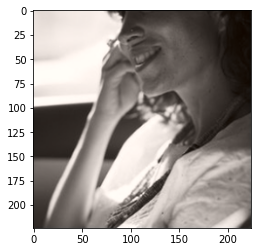

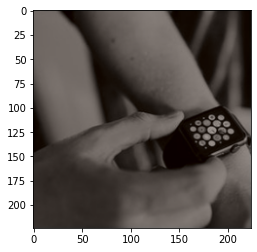

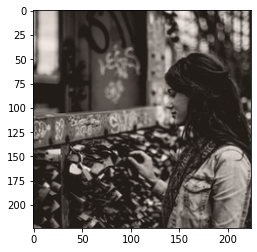

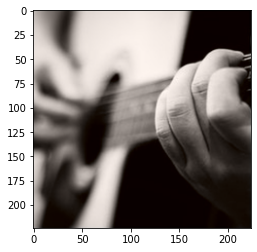

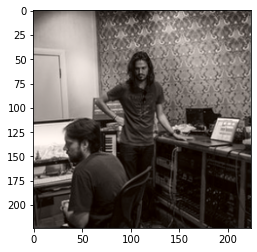

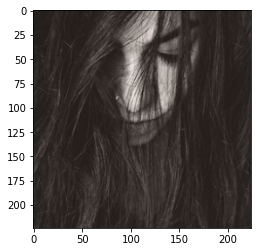

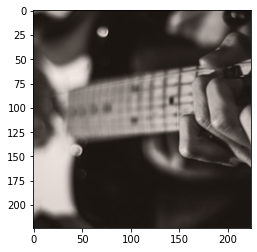

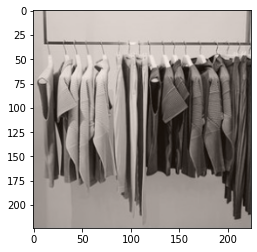

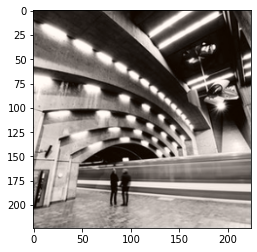

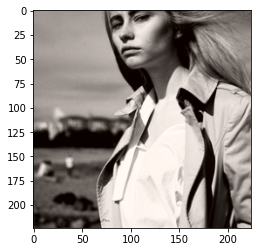

In [74]:
some_results = !ls results/ | tail -n 10

for i in some_results:
  plt.figure()
  plt.imshow(img_to_array(load_img("results/" + i)).astype('uint8'))

The model seems to be producing images in a brownish shade. The images in this data set are taken by professional photographers with a frequently brownish theme.

A next step would be to train on another dataset and see how the results would differ.